In [1]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5874613/

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns 
import matplotsoccer as mps
import warnings
warnings.filterwarnings('ignore')

In [4]:
import Metrica_IO as mio
import Metrica_Viz as mviz

In [5]:
DATADIR = "C:\\Users\\Michael\Documents\\MACF courses material\\Fall 2022\\STAT 497\\Project1-master\\sample-data-master\\sample-data-master\\data"
game_id = 2 # let's look at sample match 2
# set up initial path to data
events = mio.read_event_data(r"C:\Users\Michael\Documents\MACF courses material\Fall 2022\STAT 497\Project1-master\sample-data-master\sample-data-master\data", game_id)

#game_id =  1 # match 1
#events = mio.read_event_data(r"C:\Users\Michael\Documents\MACF courses material\Fall 2022\STAT 497\Project1-master\sample-data-master\sample-data-master\data", game_id)


In [6]:
#Data cleaning
# Bit of housekeeping: unit conversion from metric data units to meters
events = mio.to_metric_coordinates(events)
events.head()


,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44


In [7]:
passes = events.loc[events["Type"]=="PASS"]
passes["Subtype"] = passes["Subtype"].fillna("Normal")

passes["Subtype"].unique()

#passes = passes.reset_index()
#array([nan, 'HEAD', 'CROSS', 'DEEP BALL', 'GOAL KICK',
#      'HEAD-INTERCEPTION-CLEARANCE'], dtype=object)

array(['Normal', 'HEAD', 'CROSS', 'DEEP BALL', 'GOAL KICK',
       'HEAD-INTERCEPTION-CLEARANCE'], dtype=object)

### Factor #3. Possession of the ball: quantify by its outcome

##### 3.	Possession is quantify by it’s outcome:
The series of passes that lead to a:
   - Goal/Shot  will have 1 point
   - Corner, free kick, throw-in ( and still in position of the ball)  will have 0.5 point
   - Lost possession will have 0 point
   
Visual Analysis of Pressure in Footbal: https://openaccess.city.ac.uk/id/eprint/17464/1/VAofPressing.pdf

In [10]:
# 
index = events[(events["Type"]=='SHOT')].index
shift_index = np.array(index)-1
app = np.append(shift_index, shift_index-1)
idx = events.iloc[app].sort_index()[events['Type']=='PASS'].index
passes['playmaker'] = passes.index.isin(idx)



index = events[(events["Type"]=='BALL LOST')].index
shift_index = np.array(index)-1
idx = events.iloc[shift_index].sort_index()[events['Type']=='PASS'].index
passes['lead_to_ball_lost'] = passes.index.isin(idx)

#passes['Playmaker'] = passes.iloc[index]

In [11]:
index = events[(events["Type"]=='SHOT')].index
passes['Possession_Outcome'] = ''
for i in np.array(index):
 
    while i > 1:
        i= i-1
        
        if events.iloc[i]['Type'] == 'PASS':
            passes.at[i, 'Possession_Outcome'] = 1
           
            
        else:
            break

index = events[(events["Type"]=='SET PIECE')].index

for i in np.array(index):
    j=i
    
    ind = True
    while j > 1:
        j= j-1
        
                
        if (events.iloc[j]['Type'] == 'PASS'):
                passes.at[j, 'Possession_Outcome'] = 0.5
                ind = False
                
        elif ((events.iloc[j]['Type'] != 'PASS') & (ind ==True)):
            if  (((events.iloc[i-1]['End Time [s]']-25) > events.iloc[j]['Start Time [s]'])):
                break
        else:
            break
            
passes['Possession_Outcome'] =np.where(passes['Possession_Outcome'] == '',0.1, passes['Possession_Outcome'] )               
        

In [15]:
# Get events by team
home_events = events[events['Team']=='Home']
away_events = events[events['Team']=='Away']

# Frequency of each event type by team
home_events['Type'].value_counts()

away_events['Type'].value_counts()

PASS              421
CHALLENGE         151
BALL LOST         113
RECOVERY          113
SET PIECE          46
BALL OUT           22
SHOT               11
FAULT RECEIVED     11
CARD                3
Name: Type, dtype: int64

In [16]:
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

# # plot player positions at ,atckick-off
# KO_Frame = events.loc[0]['Start Frame']
# fig,ax = mviz.plot_frame( tracking_home.loc[KO_Frame], tracking_away.loc[KO_Frame] )

Reading team: home
Reading team: away


In [77]:
#home keeper #11 
#away keeper #25 
#KO_Frame = events.loc[0]['Start Frame']
#tracking_home.loc[KO_Frame]

In [18]:
st = events.loc[events["Type"]=="PASS"]
events['Type'].value_counts()

PASS              964
CHALLENGE         311
RECOVERY          248
BALL LOST         233
SET PIECE          80
BALL OUT           49
SHOT               24
FAULT RECEIVED     20
CARD                6
Name: Type, dtype: int64

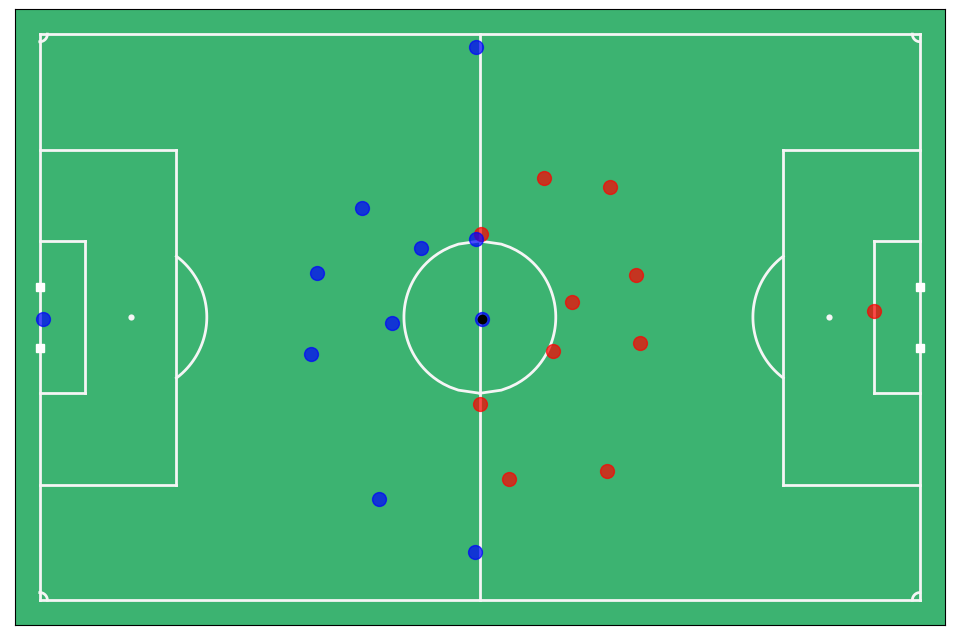

In [19]:
# # plot player positions at ,atckick-off
KO_Frame = events.loc[0]['Start Frame']
fig,ax = mviz.plot_frame( tracking_home.loc[KO_Frame], tracking_away.loc[KO_Frame] , )

### Factor #1. Openness

1. For openness, we look at the pressure of the opponent team (a), and it’s magnitude (b):
a.	Closest opponent player to the passer in meter (and similar for the receiver)
    - The distance can be quantify from a continuous scale from 0-1, where 1 means that opponent player is tackling (less than 1m of the player)
    -closest_opponent
    

2. For pressure magnitude: Count # of nearby players around passer and receiver with a radius of 10m
    - Pressure magnitude evolves similar to a logarithmic function as # of opponent plys increase


In [20]:
#Through ball
temp = tracking_home.merge(tracking_away, on = ['Period', 'Time [s]', 'Frame'], how ="left")

#nbr_ply_vector = pd.Series()  
nbr_ply_vector = []
nbr_ply_vector2 =[]
distance_vector = []
#map tracking to event data
for i, row in passes.iterrows():
    #passer
    passer_name =''
    passer_nbr = row['From'].split('Player', 1)
    passer_name = row['Team'] + '_' + passer_nbr[1].replace(" ", "")
    
    #receiver
    receiver_name =''
    receiver_nbr = row['To'].split('Player', 1)
    receiver_name = row['Team'] + '_' + receiver_nbr[1].replace(" ", "")
    if row['Team'] == 'Away':
        opp_team = temp.loc[row["Start Frame"]].filter(like='Home')
        
        opp_team_end = temp.loc[row["End Frame"]].filter(like='Home')
        
    else:
        opp_team = temp.loc[row["Start Frame"]].filter(like='Away')
        
        opp_team_end = temp.loc[row["End Frame"]].filter(like='Away')
    
    i=0
    count_ply_near_r =0
    count_ply_near_p =0
    min_distance_1 = 106
    min_distance_2 = 106
    for i in range(int(len(opp_team)/2)):
        passer = temp.loc[row["Start Frame"]][[passer_name + '_x', passer_name + '_y']]
        distance_1 = np.linalg.norm(passer.values - opp_team[[i, i+1]].values)
        min_distance_1 = min(min_distance_1, distance_1) # take the closest opponent player
        
        if (distance_1 < 10) :
            count_ply_near_r +=1
        receiver = temp.loc[row["End Frame"]][[receiver_name + '_x', receiver_name + '_y']]
        distance_2 = np.linalg.norm(receiver.values - opp_team_end[[i, i+1]].values)
        min_distance_2 = min(min_distance_2, distance_2) # take the closest opponent player
        
        if (distance_2  < 10):
            count_ply_near_p +=1
            
        temp_vect = [min_distance_1, min_distance_2] 
        count_ply_nearby = [count_ply_near_p, count_ply_near_r] 
        count_ply_nearby_total = count_ply_near_p+ count_ply_near_r
        i+=1
    
    distance_vector.append(temp_vect)
   
    nbr_ply_vector.append(count_ply_nearby)
    nbr_ply_vector2.append(count_ply_nearby_total)    

passes['nbr_nerby_ply'] = nbr_ply_vector
passes['total_nbr_nerby_ply'] = nbr_ply_vector2
passes['closest_opponent'] = distance_vector

#compare end ball location to opponent players

# determine whether through ball

In [79]:
12*8

96

### Factor #2.Detect type of passes
#### Definition: all passes that are in the attacking 60% of the pitch and must travel 25% closer to the goal from the starting pass point
#### Progressive passes: in the attacking 60% of the pitch and must travel 25% closer to the goal from the starting pass point
#### 	Neutral passes: in the attacking 60% of the pitch and travel btw 0% to 25% closer to the goal from the starting pass point
#### 	Defensive passes: otherwise

#### # of outplayed players and xTreat could be a sub-parameter for the progressive passes to provide greater deept
#### 

In [26]:


beg_away = np.sqrt(np.square(53-passes['Start X']) + np.square(0 - passes['Start Y']))
end_away = np.sqrt(np.square(53 - passes['End X']) + np.square(0 - passes['End Y']))

beg_home = np.sqrt(np.square(-53-passes['Start X']) + np.square(0 - passes['Start Y']))
end_home = np.sqrt(np.square(-53 - passes['End X']) + np.square(0 - passes['End Y']))

condition = (
    # more than 25% closer to goal

    # within the attacking area
    (
     ((end_away / beg_away < .75) & (passes['End X']> -10.6) &  (passes['End X'] <=53) & (passes['Period'] == 1) & (passes['Team'] == 'Away' ))  |
    ( (end_home / beg_home < .75) & (passes['End X']< 10.6) &  (passes['End X'] >= -53) & (passes['Period'] == 2) & (passes['Team'] == 'Away' )) |
      ((end_home / beg_home < .75) & (passes['End X']< 10.6) &  (passes['End X'] >= -53) & (passes['Period'] == 1) & (passes['Team'] == 'Home' )) |
    ( (end_away / beg_away < .75) & (passes['End X']> -10.6) &  (passes['End X'] <=53) & (passes['Period'] == 2) & (passes['Team'] == 'Home' )) 
       
    )

)

passes['Type_of_Pass'] = np.where(condition , "progressive", "No type")

#### Now that we have the progressive passes, let's find the neutral and defensive passes

In [27]:
res = passes[passes['Type_of_Pass'] !="progressive"]


beg_away = np.sqrt(np.square(53-res['Start X']) + np.square(0 - res['Start Y']))
end_away = np.sqrt(np.square(53 - res['End X']) + np.square(0 - res['End Y']))

beg_home = np.sqrt(np.square(-53-res['Start X']) + np.square(0 - res['Start Y']))
end_home = np.sqrt(np.square(-53 - res['End X']) + np.square(0 - res['End Y']))

condition = (
    # more than 25% closer to goal

    # within the attacking area
    (
     ((end_away / beg_away > .75) & (end_away / beg_away < 1) & (res['End X']> -10.6) &  (res['End X'] <=53) & (res['Period'] == 1) & (res['Team'] == 'Away' ))  |
    ( (end_home / beg_home > .75) & (end_home / beg_home < 1) & (res['End X']< 10.6) &  (res['End X'] >= -53) & (res['Period'] == 2) & (res['Team'] == 'Away' )) |
      ((end_home / beg_home > .75) & (end_home / beg_home < 1) & (res['End X']< 10.6) &  (res['End X'] >= -53) & (res['Period'] == 1) & (res['Team'] == 'Home' )) |
    ( (end_away / beg_away > .75) & (end_away / beg_away < 1) & (res['End X']> -10.6) &  (res['End X'] <=53) & (res['Period'] == 2) & (res['Team'] == 'Home' )) 
       
    )

)

res['Type_of_Pass'] = np.where(condition , "neutral", 'defensive')
passes = res.append(passes[passes['Type_of_Pass'] == 'progressive'])

## Factor #2b .Detect the number of opponent player “outplayed” in the x-direction

In [28]:
home_ply = tracking_home.filter(like='Home').filter(like='_x').columns
away_passes = passes[passes['Team']=='Away'].reset_index(names = ['Pass_loc']).merge(tracking_home, left_on = 'Start Frame', right_on ='Frame', how ="left")



matrix_away = away_passes[['Pass_loc']].copy()
for player in home_ply:
    crossed_ply_condition = (away_passes[player].between(away_passes['Start X'],away_passes['End X']) |
                         away_passes[player].between(away_passes['End X'],away_passes['Start X']))

    matrix_away[player]= crossed_ply_condition

matrix_away['count'] = matrix_away[home_ply].sum(axis=1)


#####################################

away_ply = tracking_away.filter(like='Away').filter(like='_x').columns

home_passes = passes[passes['Team']=='Home'].reset_index(names = ['Pass_loc']).merge(tracking_away, left_on = 'Start Frame', right_on ='Frame', how ="left")


matrix_home = home_passes[['Pass_loc']].copy()
for player in away_ply:
    crossed_ply_condition = (home_passes[player].between(home_passes['Start X'],home_passes['End X']) |
                         home_passes[player].between(home_passes['End X'],home_passes['Start X']))
    
    matrix_home[player]= crossed_ply_condition

matrix_home['count'] = matrix_home[away_ply].sum(axis=1)

master = matrix_home[['Pass_loc', 'count']].append(matrix_away[['Pass_loc', 'count']])

#merge results to passes dataframe
passes['nbr_crossed_ply'] = master.sort_values("Pass_loc")['count'].values


### velocity of passes


In [31]:
distance = np.sqrt(np.square(passes['End X']-passes['Start X']) + np.square(passes['End Y'] - passes['Start Y']))
time_elapse = passes['End Time [s]'] - passes['Start Time [s]']
speed = distance/time_elapse #m/s
passes['velocity (m/s)'] = speed

In [33]:
passes[passes['total_nbr_nerby_ply']==10]

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,playmaker,lead_to_ball_lost,Possession_Outcome,nbr_nerby_ply,total_nbr_nerby_ply,closest_opponent,Type_of_Pass,nbr_crossed_ply,velocity (m/s)
515,Home,PASS,HEAD,1,33427,1337.08,33446,1337.84,Player7,Player9,-18.02,-20.40,-13.78,-17.68,False,False,0.1,"[5, 5]",10,"[0.3335578780361811, 0.7256059274840573]",defensive,2,6.628236
541,Away,PASS,Normal,1,35654,1426.16,35674,1426.96,Player18,Player22,19.08,28.56,23.32,31.96,False,False,0.5,"[5, 5]",10,"[1.9895490174408843, 2.7341444260316634]",neutral,3,6.793563
746,Away,PASS,Normal,1,49525,1981.00,49545,1981.80,Player18,Player22,20.14,29.24,24.38,19.72,False,False,0.5,"[6, 4]",10,"[2.253867274264393, 0.5019531360595327]",neutral,1,13.026895
992,Home,PASS,Normal,1,65699,2627.96,65734,2629.36,Player5,Player7,-33.92,-31.96,-27.56,-32.64,False,False,0.1,"[5, 5]",10,"[3.1767217064766644, 0.6361862871832386]",defensive,2,4.568749
1135,Away,PASS,Normal,2,77017,3080.68,77037,3081.48,Player22,Player23,-15.90,-29.92,-23.32,-20.40,False,False,0.1,"[7, 3]",10,"[3.090895358953452, 1.1328826438779964]",neutral,0,15.087598
1255,Away,PASS,Normal,2,83739,3349.56,83769,3350.76,Player19,Player23,5.30,3.40,-10.60,-17.00,False,False,0.5,"[4, 6]",10,"[4.765845345707306, 3.4572628355391224]",neutral,2,21.553712
1354,Away,PASS,Normal,2,91245,3649.80,91268,3650.72,Player21,Player24,-16.96,-32.64,-12.72,-31.96,False,False,0.1,"[5, 5]",10,"[4.329429177709231, 2.1353964181856226]",defensive,0,4.667589


In [38]:
passes[passes['Type_of_Pass']=='progressive']['velocity (m/s)'].mean()

passes[passes['Type_of_Pass']=='defensive']['velocity (m/s)'].mean()

11.071463633664136

Text(-14.900000000000002, -28.919999999999995, 'F1: 0')

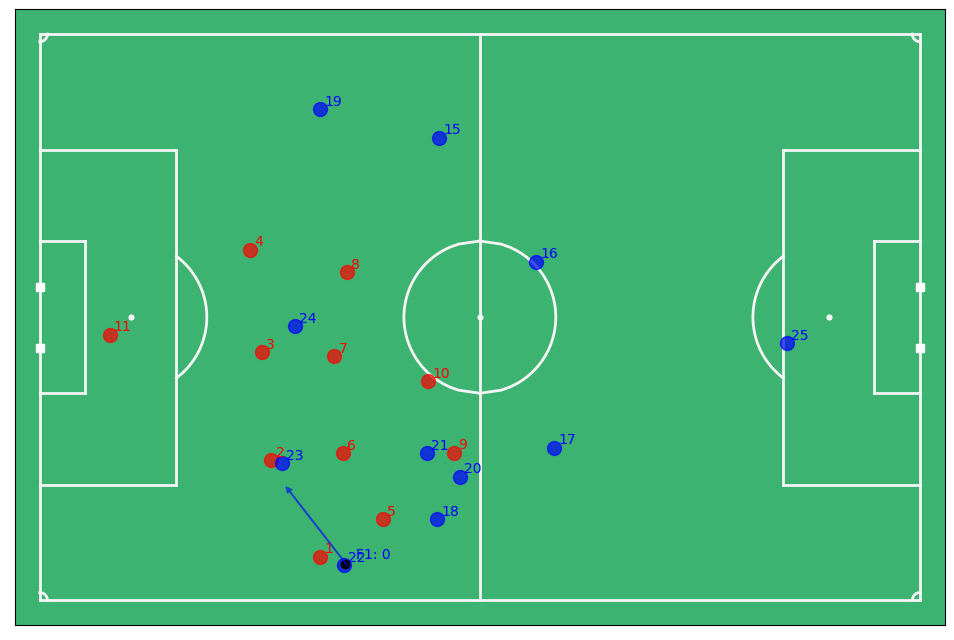

In [39]:
# We can also plot a single pass and all the positions of each team
pass_of_interest_loc = 1135

pass_frame_number = passes.loc[pass_of_interest_loc]["Start Frame"]

fig, ax = mviz.plot_frame( tracking_home.loc[pass_frame_number], tracking_away.loc[pass_frame_number],annotate=True )
ax.annotate("", xy=passes.loc[pass_of_interest_loc][['End X', 'End Y']], xytext=passes.loc[pass_of_interest_loc][['Start X', 'Start Y']], alpha=0.5, arrowprops=dict(
                    alpha=0.5, width=0.5, headlength=4.0, headwidth=4.0, color="blue"), annotation_clip=False)
textstring = 'F1: ' + str(passes.loc[pass_of_interest_loc]['nbr_crossed_ply'])
ax.text(passes.loc[pass_of_interest_loc]['Start X']+1, passes.loc[pass_of_interest_loc]['Start Y']+1,  textstring, fontsize=10, color='blue')



(<Figure size 1200x800 with 1 Axes>, <AxesSubplot: >)

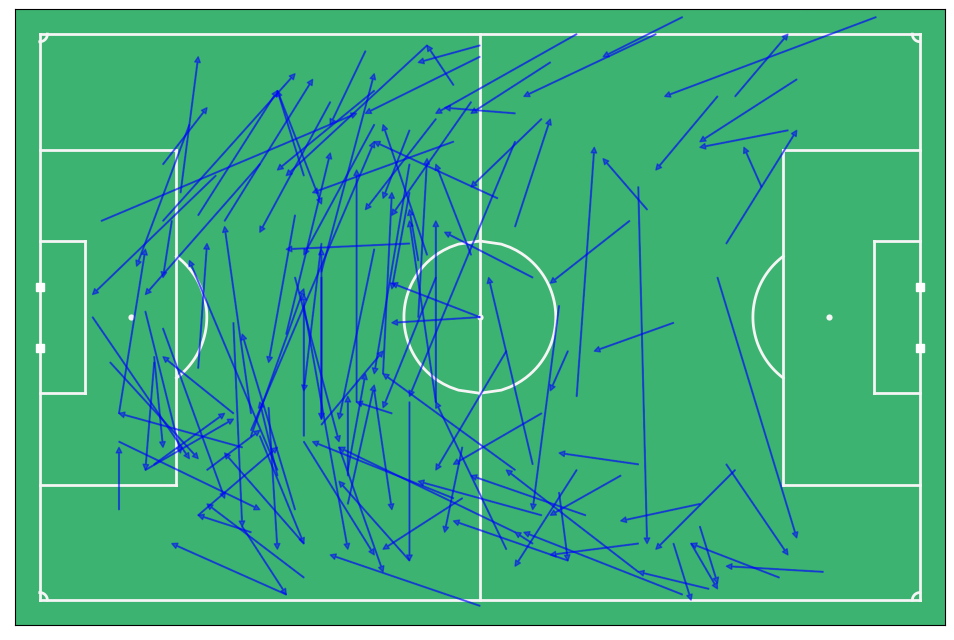

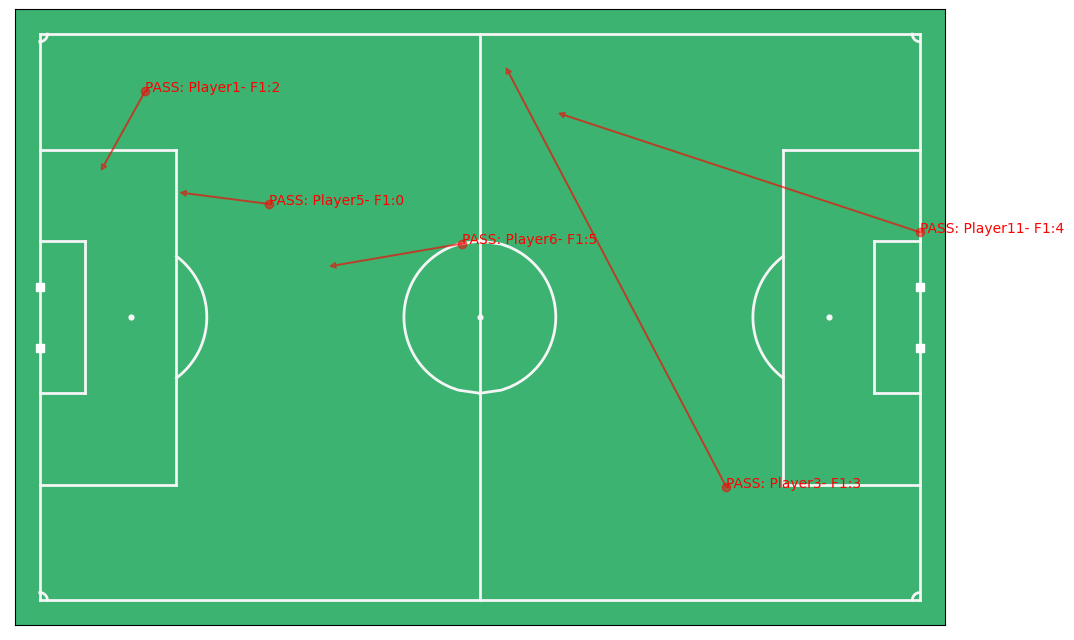

In [78]:
fig, ax= mviz.plot_pitch()


# Two ways to plot the first 4 passes:
for index, row in passes[passes["Type_of_Pass"]== 'defensive' ].iterrows():
       
    if ((row['Team'] == 'Away') & (row['Period'] == 1)):
        ax.annotate("", xy=row[['End X', 'End Y']], xytext=row[['Start X', 'Start Y']], alpha=0.5, arrowprops=dict(
                    alpha=0.5, width=0.5, headlength=4.0, headwidth=4.0, color="blue"), annotation_clip=True)
   # else:
    #    ax.annotate("", xy=row[['End X', 'End Y']], xytext=row[['Start X', 'Start Y']], alpha=0.5, arrowprops=dict(
     #             alpha=0.5, width=0.5, headlength=4.0, headwidth=4.0, color="red"), annotation_clip=False)
    
# That's essentially all that's in the plot_events function
mviz.plot_events( passes[passes["Type_of_Pass"]== 'progressive' ].iloc[:5], indicators = ['Marker','Arrow'], annotate=True)

### Factor #4. Expected Threat based on Origin and Destination zone

#### Origin and destination zone (difficulty of pass based on pitch area)
 - Pitch is divided into 18 zones will there respective weight (ie: based on xG score)
 - Quantify by: (weight in destination zone) - (weight in origin zone) =  score
 -	Positive score means ball moving closer to the goal
 
 Introducing Expected Threat (xT): https://karun.in/blog/expected-threat.html#visualizing-xt



In [41]:

import requests
#Import xT Grid, turn it into an array, and then get how many rows and columns it has

response = requests.get('https://karun.in/blog/data/open_xt_12x8_v1.json') #same data in the json file and csv file 
#xT = pd.read_csv(r"C:\Users\Michael\Documents\MACF courses material\Fall 2022\soccer_notebook_lab-master\xT\xT_Grid.csv", header=None)
xT = response.json()
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

<AxesSubplot: >

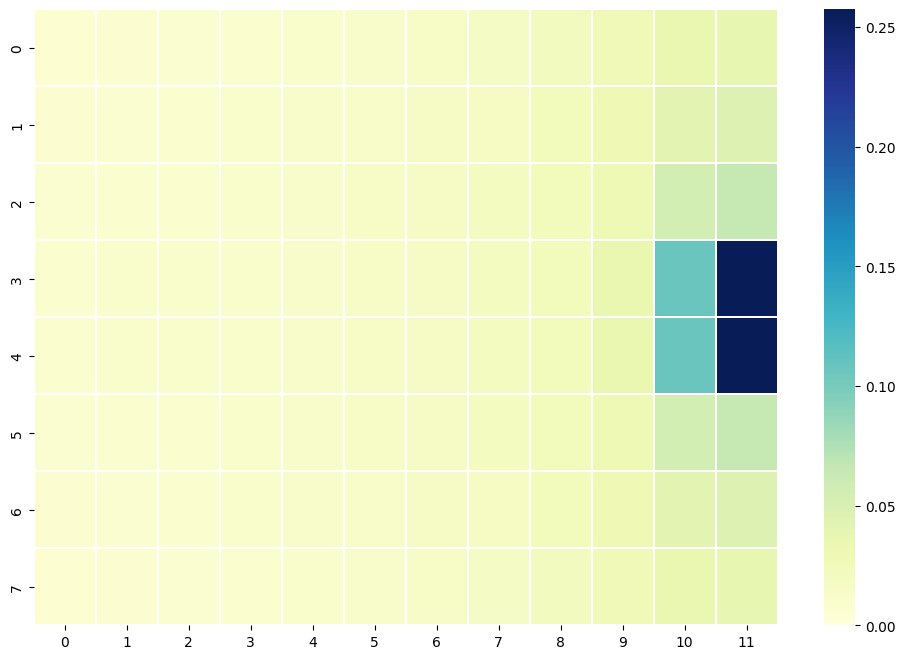

In [42]:
max = np.amax(xT)
fig ,ax = plt.subplots(figsize=(xT_cols, xT_rows))
ax.invert_yaxis()
sns.heatmap(xT , vmin=0, vmax=max, cmap="YlGnBu", linewidths=0.25, xticklabels=True,yticklabels=True)


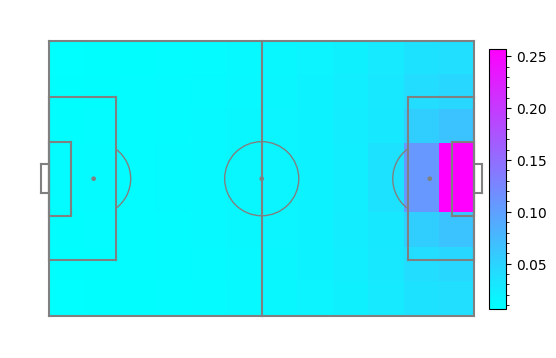

<AxesSubplot: >

In [76]:
mps.heatmap(xT,cmap="cool", linecolor="grey", cbar="True")


Text(40.22, -29.599999999999998, 'F1: 4')

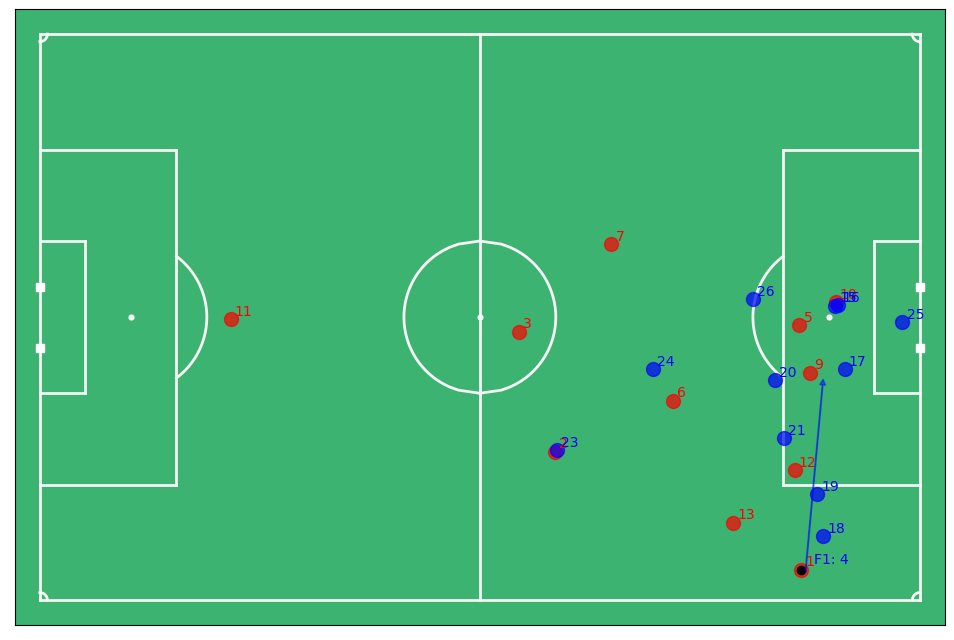

In [45]:
# We can also plot a single pass and all the positions of each team
pass_of_interest_loc = 1680                  

pass_frame_number = passes.loc[pass_of_interest_loc]["Start Frame"]

fig, ax = mviz.plot_frame( tracking_home.loc[pass_frame_number], tracking_away.loc[pass_frame_number],annotate=True )
ax.annotate("", xy=passes.loc[pass_of_interest_loc][['End X', 'End Y']], xytext=passes.loc[pass_of_interest_loc][['Start X', 'Start Y']], alpha=0.5, arrowprops=dict(
                    alpha=0.5, width=0.5, headlength=4.0, headwidth=4.0, color="blue"), annotation_clip=False)
textstring = 'F1: ' + str(passes.loc[pass_of_interest_loc]['nbr_crossed_ply'])
ax.text(passes.loc[pass_of_interest_loc]['Start X']+1, passes.loc[pass_of_interest_loc]['Start Y']+1,  textstring, fontsize=10, color='blue')

### Expected Threat

In [46]:
#Bin Data for xT
df =pd.DataFrame()
# We use a pandas method called .cut --> https://pandas.pydata.org/docs/reference/api/pandas.cut.html
# We say labels=False because we want the integer locator of the bin
condition_1 = passes[(passes['Team'] == 'Away') & (passes['Period'] ==1) | (passes['Team'] == 'Home') & (passes['Period'] ==2)]

condition_1['x1_bin'] = pd.cut(condition_1['Start X'], bins=xT_cols, labels=False)
condition_1['y1_bin'] = pd.cut(condition_1['Start Y'], bins=xT_rows, labels=False)
condition_1['x2_bin'] = pd.cut(condition_1['End X'], bins=xT_cols, labels=False)
condition_1['y2_bin'] = pd.cut(condition_1['End Y'], bins=xT_rows, labels=False)


condition_2 = passes[(passes['Team'] == 'Away') & (passes['Period'] ==2) | (passes['Team'] == 'Home') & (passes['Period'] ==1)]

condition_2['x1_bin'] = pd.cut(-condition_2['Start X'], bins=xT_cols, labels=False)
condition_2['y1_bin'] = pd.cut(-condition_2['Start Y'], bins=xT_rows, labels=False)
condition_2['x2_bin'] = pd.cut(-condition_2['End X'], bins=xT_cols, labels=False)
condition_2['y2_bin'] = pd.cut(-condition_2['End Y'], bins=xT_rows, labels=False)

passes = condition_2.append(condition_1)

# reaganged format variable from [(X,Y), (X,Y), (X,Y)]to  [(X,X,X), (Y,Y,Y)]
passes['xThreat_Pass'] = xT[tuple(zip(*passes[['y2_bin', 'x2_bin']].values))] - xT[tuple(zip(*passes[['y1_bin', 'x1_bin']].values))] 

In [49]:
passes[(passes['xThreat_Pass']<0.01) & (passes['Type_of_Pass'] != 'progressive')].head()
#passes[(passes['progressive'] != 'False')].count()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,playmaker,lead_to_ball_lost,Possession_Outcome,nbr_nerby_ply,total_nbr_nerby_ply,closest_opponent,Type_of_Pass,nbr_crossed_ply,velocity (m/s),x1_bin,y1_bin,x2_bin,y2_bin,xThreat_Pass
28,Home,PASS,Normal,1,1467,58.68,1489,59.56,Player1,Player11,46.64,21.08,53.00,10.20,False,False,0.1,"[0, 0]",0,"[24.146668273772256, 28.89895448423697]",defensive,0,14.321068,0,1,0,2,0.001379
36,Home,PASS,HEAD,1,1672,66.88,1693,67.72,Player6,Player7,19.08,14.96,19.08,8.84,False,True,0.1,"[2, 1]",3,"[5.158233928662023, 4.753802913205381]",defensive,7,7.285714,3,2,3,2,0.000000
52,Home,PASS,Normal,1,2414,96.56,2440,97.60,Player3,Player8,16.96,-24.48,1.06,-29.92,False,False,0.1,"[2, 0]",2,"[15.240369010230694, 3.874641588173034]",neutral,3,16.158527,4,6,6,7,0.002589
53,Home,PASS,Normal,1,2465,98.60,2493,99.72,Player8,Player4,2.12,-29.92,10.60,-31.96,False,False,0.1,"[1, 2]",3,"[2.698206456148232, 4.275410147716814]",defensive,3,7.787434,5,7,4,7,-0.001221
54,Home,PASS,Normal,1,2511,100.44,2546,101.84,Player4,Player3,11.66,-31.96,27.56,-25.16,False,False,0.1,"[0, 1]",1,"[2.5343732328131976, 14.49361906462289]",defensive,2,12.352187,4,7,2,6,-0.001839


###  Scorring mechanic

In [68]:

temp_df =pd.DataFrame()

for type_pass in ['progressive', 'neutral', 'defensive']:
    data_set = passes[passes['Type_of_Pass'] == type_pass]
    if (type_pass == 'progressive'):
        weight =0.6
    elif (type_pass == 'neutral'):
         weight =0.5
    elif (type_pass== 'defensive'):
         weight =0.4
    data_set['possession_score'] = (1- weight) * (1 - (1/(1+data_set['Possession_Outcome'])) * np.exp(-data_set['total_nbr_nerby_ply']/2))        
    data_set['scoring_score'] = (weight) *  (1 - 0.8* np.exp(-2 * data_set['xThreat_Pass'] *(data_set['velocity (m/s)']/data_set['velocity (m/s)'].mean())))
    data_set['Improved_Impact_Score'] = data_set['possession_score'] +data_set['scoring_score'] 
    
    temp_df = temp_df.append(data_set)
    
passes = temp_df

In [72]:
passes.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,playmaker,lead_to_ball_lost,Possession_Outcome,nbr_nerby_ply,total_nbr_nerby_ply,closest_opponent,Type_of_Pass,nbr_crossed_ply,velocity (m/s),x1_bin,y1_bin,x2_bin,y2_bin,xThreat_Pass,possession_score,scoring_score,Improved_Impact_Score
29,Home,PASS,Normal,1,1489,59.56,1578,63.12,Player11,Player9,53.00,10.20,9.54,24.48,False,False,0.1,"[2, 0]",2,"[28.89895448423697, 0.3965271682999775]",progressive,4,12.849980,0,2,5,1,0.004966,0.266226,0.123564,0.389789
55,Home,PASS,Normal,1,2603,104.12,2708,108.32,Player3,Player1,29.68,-20.40,3.18,29.92,False,False,0.1,"[0, 0]",0,"[16.083279470406527, 16.2457624684839]",progressive,3,13.540802,2,6,5,0,0.003060,0.036364,0.122317,0.158681
58,Home,PASS,Normal,1,2906,116.24,2923,116.92,Player6,Player10,-2.12,8.84,-18.02,6.12,False,False,0.1,"[2, 0]",2,"[16.169967601760987, 2.5309519884818004]",progressive,5,23.722024,6,2,8,3,0.006996,0.266226,0.129213,0.395439
79,Home,PASS,Normal,1,4261,170.44,4291,171.64,Player5,Player9,-25.44,13.60,-36.04,14.96,False,False,1,"[2, 0]",2,"[12.186001855243584, 3.3076978096555307]",progressive,0,8.905741,8,2,10,2,0.030789,0.326424,0.135128,0.461552
81,Home,PASS,Normal,1,4361,174.44,4376,175.04,Player1,Player9,-40.28,27.20,-45.58,17.68,True,False,1,"[1, 1]",2,"[4.406392485287709, 5.786494330801681]",progressive,2,18.159815,10,0,11,1,0.011626,0.326424,0.131691,0.458115


(array([178.,   0.,  13.,  51., 134.,  40.,  86., 158., 103., 100.,  59.,
         38.,   2.,   1.,   1.]),
 array([0.12510861, 0.17324036, 0.22137211, 0.26950386, 0.31763561,
        0.36576736, 0.41389911, 0.46203086, 0.51016261, 0.55829437,
        0.60642612, 0.65455787, 0.70268962, 0.75082137, 0.79895312,
        0.84708487]),
 <BarContainer object of 15 artists>)

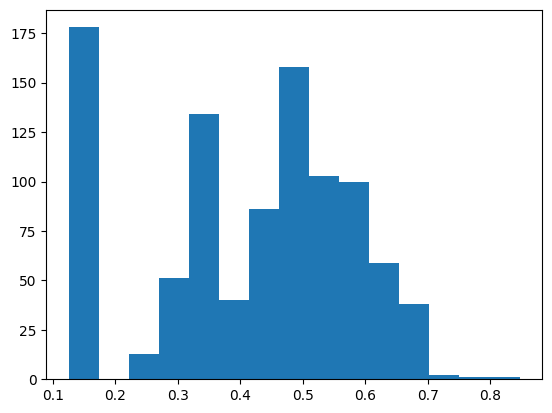

In [75]:
plt.hist(passes['Improved_Impact_Score'], 15, weights=None)